<a href="https://colab.research.google.com/github/danielmunozji/Procesamiento-de-datos-secuenciales/blob/main/Proyecto_Final_PDS_DL_CLEAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrega final de curso - Generación de modelos NLP

## Presentado por: Daniel Muñoz & Alejandro Bolaños

## Punto 1. Modelo NLP con Transformers.

El Punto 1 del proyecto se centra en la construcción de un sistema de traducción automática neuronal utilizando modelos basados en la arquitectura Transformer, una de las innovaciones más importantes en el procesamiento de lenguaje natural (NLP). Esta sección busca demostrar el dominio de conceptos fundamentales de los modelos modernos de secuencia, así como la capacidad para entrenar, evaluar y desplegar un modelo real de traducción en un entorno práctico.

### Etapa 1. Instalación de librerías y verificación del entorno

En esta primera etapa se realiza el acondicionamiento del entorno de trabajo para garantizar que todas las herramientas necesarias estén disponibles antes de iniciar el procesamiento y entrenamiento de los modelos. Se emplea pip para instalar las librerías fundamentales del proyecto, entre ellas:

 **- datasets:** permite cargar y gestionar corpus desde Hugging Face Hub.

 **- transformers:** proporciona los modelos preentrenados, tokenizadores y utilidades de entrenamiento.

 **- accelerate:** optimiza el entrenamiento en CPU/GPU.

 **- evaluate y sacrebleu:** usados para calcular métricas de calidad en traducción.

 **- gradio:** permite construir interfaces web simples para probar los modelos entrenados.

Una vez instaladas estas dependencias, se importa la librería transformers y se verifica su versión. Este paso es importante porque las funciones internas de Hugging Face cambian con las actualizaciones, por lo que confirmar que la versión instalada es compatible evita errores posteriores en:

 - TrainingArguments
 - Trainer
 - AutoTokenizer
 - AutoModelForSeq2SeqLM
 - pipelines
 - métricas y utilidades

Con esto, el entorno queda adecuadamente configurado para proceder con las etapas siguientes del proyecto, donde se cargarán los modelos, los datasets y se realizará el preprocesamiento y entrenamiento.

In [1]:
# Etapa 1. Instalación de librerias // Link de dataset: https://huggingface.co/datasets/Thermostatic/OPUS-100-EN-ES

# Se realiza la descarga de las dependencias necesarias para trabajos de deep learning para NLP
!pip install -q datasets transformers accelerate evaluate sacrebleu gradio

# Se realiza la importación del modelo mas actual para trabajos y se valida la versión
# con el fin de verificar si es apta para nuestro modelo
import transformers
print(transformers.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.7 MB/s eta 0:00:00
4.57.2


In [2]:
# 1.1 Validación

from transformers import TrainingArguments, Trainer
import transformers

print("Versión transformers:", transformers.__version__)
print("TrainingArguments viene de:", TrainingArguments.__module__)


Versión transformers: 4.57.2
TrainingArguments viene de: transformers.training_args


### Etapa 2. Importación de librerías y configuración básica del entorno

En esta etapa se incorporan las librerías esenciales para el procesamiento de datos, manejo de modelos de lenguaje y evaluación del desempeño. Estas importaciones permiten preparar el entorno de trabajo antes de cargar los datasets y definir los modelos que serán utilizados en el proyecto.

Se incluyen módulos estándar de Python como:

 - random, numpy y torch, necesarios para la manipulación de datos y la creación de tensores.

 - Librerías de Hugging Face, tales como datasets, AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, TrainingArguments y Trainer, que permiten cargar corpus, tokenizar texto, inicializar modelos preentrenados y configurar procesos de entrenamiento.

 - La librería evaluate, utilizada posteriormente para calcular métricas como SacreBLEU en la evaluación de la traducción automática.

Además, se establecen semillas de aleatoriedad (random seeds) para asegurar la reproducibilidad del experimento. Esto significa que cualquier proceso aleatorio —como particionamiento de datos o inicialización de pesos— producirá los mismos resultados al ejecutar nuevamente el notebook.

Finalmente, se realiza una verificación del hardware disponible (CPU o GPU).
Si Google Colab asigna una GPU, el proyecto puede ejecutarse de forma considerablemente más rápida; de lo contrario, el procesamiento se realizará en CPU. Esta detección automática garantiza que el código utilice el recurso más eficiente disponible, lo cual es especialmente relevante para modelos basados en Transformers.

In [3]:
# Etapa 2. Importación y configuración basica

# Librerias fundamentales para manipulación de datos y creación de tensores
import random
import numpy as np
import torch

# Dependencias para carga y gestionamiento de las variables a ingresar por parte
# del dataset seleccionado
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    Trainer,
)

# Dependencia que permite evaluar desempeño entre modelos.
import evaluate

# Semillas para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Validación del elemento de procesamiento fisico disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

### Etapa 3. Carga del dataset y detección automática de columnas

En esta etapa se realiza la importación del dataset paralelo utilizado para el entrenamiento del modelo de traducción. El corpus seleccionado proviene del repositorio Hugging Face Hub y corresponde a Thermostatic/OPUS-100-EN-ES, un conjunto de datos que contiene pares de oraciones alineadas entre inglés y español.

El proceso se desarrolla en tres pasos principales:

1. Carga del dataset y verificación de estructura

Se utiliza la función load_dataset() para descargar automáticamente los datos y obtener sus particiones (splits), tales como train, validation y test. Esta inspección inicial permite confirmar si el dataset ya provee divisiones estándar o si será necesario crearlas manualmente en etapas posteriores.

2. Diagnóstico de las columnas del corpus

Los datasets paralelos no siempre utilizan los mismos nombres de columna para identificar los idiomas origen y destino. Por ello, se muestra un ejemplo de registro con el fin de visualizar las llaves disponibles.
Dependiendo del origen del corpus, los nombres de las columnas pueden variar entre:

en / es

English / Spanish

source / target

text / translation

entre otros.

Esta inspección es esencial para garantizar que el modelo reciba correctamente el texto de entrada y la referencia esperada durante el entrenamiento.

3. Detección automática de columnas de idioma

Con el objetivo de hacer el código robusto y compatible con distintos datasets paralelos, se implementa un mecanismo de detección dinámica. Este proceso revisa las columnas encontradas y las compara contra nombres típicos utilizados en datasets bilingües.
Una vez identificadas, se asignan automáticamente a:

src_col → columna del idioma origen (inglés)

tgt_col → columna del idioma destino (español)

Este enfoque evita errores derivados de la variabilidad en la estructura de los datasets y facilita la reutilización del código con otros corpus de traducción.

In [4]:
# Etapa 3. Carga del dataset

DATASET_NAME = "Thermostatic/OPUS-100-EN-ES" # Identificador del modelo a utilizar

# Cargar dataset
raw_datasets = load_dataset(DATASET_NAME) # Obtención de los splits que tiene el modelo
print(raw_datasets)

# Obtener nombres de splits directamente
split_names = list(raw_datasets.keys())
print("Splits disponibles:", split_names)

# Tomar un ejemplo de algún split para ver columnas
sample_split = split_names[0]
sample_batch = raw_datasets[sample_split][0]
print("Ejemplo de registro:", sample_batch)

cols = list(sample_batch.keys())
print("Columnas detectadas:", cols)

# Detectar columnas de inglés y español
if "en" in cols and "es" in cols:
    src_col, tgt_col = "en", "es"
elif "source" in cols and "target" in cols:
    src_col, tgt_col = "source", "target"
elif "English" in cols and "Spanish" in cols:
    src_col, tgt_col = "English", "Spanish"
else:
    raise ValueError(f"No se encontraron columnas típicas de paralelo. Columnas: {cols}")

print(f"Usaremos '{src_col}' como inglés (origen) y '{tgt_col}' como español (destino).")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

english-to-spanish-translations.parquet:   0%|          | 0.00/93.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['English', 'Spanish'],
        num_rows: 1000000
    })
})
Splits disponibles: ['train']
Ejemplo de registro: {'English': "It was the asbestos in here, that's what did it!", 'Spanish': 'Fueron los asbestos aquí. ¡Eso es lo que ocurrió!'}
Columnas detectadas: ['English', 'Spanish']
Usaremos 'English' como inglés (origen) y 'Spanish' como español (destino).


### Etapa 4. Construcción de splits: Train / Valid / Test

En esta etapa se organiza el dataset descargado en las tres particiones esenciales para el entrenamiento y evaluación del modelo de traducción: train, validation y test. Este proceso es indispensable para garantizar una correcta generalización del modelo y evitar que se evalúe sobre datos que ya ha visto durante el entrenamiento.

1. Inspección de los splits disponibles

Inicialmente, se imprime la lista de particiones (splits) que provee el dataset original desde el Hugging Face Hub. Dependiendo de su origen, un corpus puede contener:

train

validation

test

o bien otras variantes menos comunes, como:

all

main

train_dev_test

Esta verificación permite determinar si el dataset ya trae una estructura estandarizada o si será necesario dividirlo manualmente.

2. Uso directo de los splits del dataset

Si el dataset contiene explícitamente las tres particiones clásicas, el código simplemente asigna:

train_ds = raw_datasets["train"]

valid_ds = raw_datasets["validation"]

test_ds = raw_datasets["test"]

Esto garantiza que se utilice la partición original diseñada para entrenamiento supervisado.

3. Generación manual de splits

En caso de que el dataset no incluya todas las particiones, se procede a crear los splits manualmente. Para ello:

se toma el único split disponible,

se mezcla aleatoriamente (shuffle) para evitar sesgos de orden,

y se divide bajo un esquema común:

80% → entrenamiento

10% → validación

10% → prueba

Este proceso asegura una estructura equilibrada incluso cuando el dataset original no la provee.

4. Control de tamaño del dataset

El código también incluye una restricción opcional para limitar el número máximo de ejemplos (por ejemplo, 50.000) en caso de que el corpus sea muy grande. Esto permite mantener un uso eficiente de memoria y tiempos de entrenamiento apropiados en Colab.

5. Resultado final

Finalmente, se imprimen los tamaños de:

train_ds

valid_ds

test_ds

Esto permite verificar que las proporciones se hayan generado correctamente y que el dataset está listo para la siguiente etapa: la selección y preparación del modelo de traducción.

In [5]:
# Etapa 4. Construcción de train - valid - test

print("Splits disponibles en el dataset:", split_names)

# Si el dataset ya trae train/validation/test
if all(s in raw_datasets for s in ["train", "validation", "test"]):
    train_ds = raw_datasets["train"]
    valid_ds = raw_datasets["validation"]
    test_ds  = raw_datasets["test"]
else:
    # Solo un split principal (p. ej. 'train')
    main_split = split_names[0]
    ds = raw_datasets[main_split]
    ds = ds.shuffle(seed=SEED)

    # (Opcional) límite máximo global de ejemplos, por si fuera enorme
    max_examples = 50000
    if len(ds) > max_examples:
        ds = ds.select(range(max_examples))

    train_size = int(0.8 * len(ds))
    valid_size = int(0.1 * len(ds))

    train_ds = ds.select(range(train_size))
    valid_ds = ds.select(range(train_size, train_size + valid_size))
    test_ds  = ds.select(range(train_size + valid_size, len(ds)))

print("Tamaño train:", len(train_ds))
print("Tamaño valid:", len(valid_ds))
print("Tamaño test :", len(test_ds))

print("Ejemplo train:", train_ds[0])


Splits disponibles en el dataset: ['train']
Tamaño train: 40000
Tamaño valid: 5000
Tamaño test : 5000
Ejemplo train: {'English': 'What measures exist to prevent their forgery etc?', 'Spanish': '¿Qué medidas existen para evitar su falsificación, etc.?'}


### Etapa 5. Selección del modelo y preparación del tokenizador (EN → ES)

En esta etapa se define el modelo de traducción neuronal que se utilizará para transformar oraciones del inglés al español. Para ello, se selecciona un modelo preentrenado de la familia MarianMT, desarrollado por Helsinki-NLP, ampliamente reconocido por su eficiencia y buen desempeño en tareas de traducción multilingüe.

1. Selección del modelo preentrenado

El modelo elegido es:

Helsinki-NLP/opus-mt-en-es

Este modelo pertenece al conjunto de modelos MarianMT, basados en la arquitectura Transformer Encoder–Decoder, y entrenados exclusivamente para tareas de traducción utilizando datos del corpus OPUS. Sus ventajas principales son:

ligereza y rapidez en inferencia,

soporte para múltiples idiomas en diferentes direcciones,

buen rendimiento incluso sin ajuste fino previo,

disponibilidad abierta y gratuita en Hugging Face.

Debido a estas características, MarianMT resulta ideal para proyectos académicos y prototipos de traducción automática como el desarrollado en este trabajo.

2. Preparación del tokenizador

Para poder utilizar el modelo, primero se debe inicializar el tokenizador, cuya función es convertir texto en secuencias de tokens e índices numéricos compatibles con la red neuronal. Se utiliza:

AutoTokenizer.from_pretrained(model_name)

Este tokenizador está específicamente alineado con el modelo MarianMT y se encarga de:

segmentar palabras en subpalabras,

aplicar truncamiento a longitudes máximas,

gestionar tokens especiales,

generar máscaras de atención,

preparar las etiquetas (labels) para el entrenamiento supervisado.

3. Carga del modelo en el dispositivo

Finalmente, el modelo (AutoModelForSeq2SeqLM) se carga en el dispositivo disponible, ya sea CPU o GPU, permitiendo ejecutar posteriormente el proceso de entrenamiento y generación de traducciones.

In [6]:
# Etapa 5. Tokenizador y modelo EN -> ES

model_name_en_es = "Helsinki-NLP/opus-mt-en-es"

tokenizer_en_es = AutoTokenizer.from_pretrained(model_name_en_es)
model_en_es = AutoModelForSeq2SeqLM.from_pretrained(model_name_en_es)
model_en_es = model_en_es.to(device)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

### Etapa 6. Dimensionamiento del conjunto de entrenamiento

El objetivo de esta etapa es controlar el tamaño del dataset que será utilizado durante el entrenamiento del modelo de traducción. Dado que los modelos basados en Transformers pueden ser costosos computacionalmente, especialmente en entornos como Google Colab, es necesario ajustar la cantidad de ejemplos para lograr un equilibrio entre:

tiempos de entrenamiento razonables,

uso eficiente de recursos,

y desempeño aceptable del modelo.

1. Submuestreo del dataset

Para lograr este equilibrio, se selecciona únicamente una fracción del corpus original:

1.000 ejemplos para entrenamiento (N_TRAIN),

200 ejemplos para validación (N_VALID).

Este proceso de submuestreo permite:

reducir significativamente el tiempo de entrenamiento,

disminuir el consumo de memoria,

facilitar iteraciones rápidas durante el desarrollo del proyecto,

y mantener un nivel suficiente de datos para que el modelo pueda aprender patrones básicos de traducción.

Aunque esta reducción limita la capacidad del modelo para generalizar completamente, es una práctica común cuando se trabaja en prototipos, demostraciones académicas o ambientes con recursos limitados.

2. Aleatorización controlada

Antes de seleccionar los subconjuntos, el dataset se mezcla (shuffle) utilizando una semilla fija. Esto garantiza:

diversidad en los ejemplos escogidos,

ausencia de sesgos derivados del orden original del dataset,

reproducibilidad total del experimento.

3. Resultado final

Al concluir esta etapa, se obtienen versiones reducidas de los splits:

train_small_en_es

valid_small_en_es

Estas particiones serán utilizadas por el modelo durante el entrenamiento y la evaluación preliminar, permitiendo avanzar en las siguientes etapas del pipeline de traducción.


In [7]:
# Etapa 6. Dimensionamiento para la velocida de entrenamiento

N_TRAIN = 1000
N_VALID = 200

train_small_en_es = train_ds.shuffle(seed=SEED).select(range(min(N_TRAIN, len(train_ds))))
valid_small_en_es = valid_ds.shuffle(seed=SEED).select(range(min(N_VALID, len(valid_ds))))

print("Tamaño train_small_en_es:", len(train_small_en_es))
print("Tamaño valid_small_en_es:", len(valid_small_en_es))


Tamaño train_small_en_es: 1000
Tamaño valid_small_en_es: 200


### Etapa 7. Procesamiento y tokenización (EN → ES)

En esta etapa se prepara el dataset para que pueda ser utilizado de forma adecuada por el modelo de traducción. El objetivo es transformar las oraciones en bruto —tanto en inglés como en español— en secuencias numéricas que el modelo pueda interpretar durante el entrenamiento supervisado.

1. Conversión de texto a tokens

El proceso inicia con una función de preprocesamiento que:

recibe los ejemplos del dataset paralelo,

toma como entrada el texto en inglés (src_col),

toma como referencia el texto en español (tgt_col),

y construye una estructura de entrenamiento adecuada para un modelo Encoder–Decoder.

Para facilitar la comprensión del modelo durante el ajuste fino, se añade un prefijo explícito al texto origen:

"translate English to Spanish: <texto>"


Este prefijo guía al modelo y mejora la consistencia en el proceso de traducción.

2. Tokenización y truncamiento

El AutoTokenizer convierte cada oración en una secuencia de tokens, los cuales posteriormente se traducen a sus correspondientes identificadores numéricos (input_ids). Durante este proceso se aplican:

truncamiento para evitar secuencias excesivamente largas,

máximas longitudes definidas para entradas y salidas (max_input_length y max_target_length),

generación de máscaras de atención (attention_mask),

creación de las etiquetas (labels) para el modelo decoder.

Este proceso es fundamental para asegurar que los datos estén correctamente estructurados para el aprendizaje supervisado.

3. Preparación del Data Collator

Una vez tokenizados los datos, se utiliza un DataCollatorForSeq2Seq, el cual automatiza varias tareas durante el entrenamiento:

aplica padding dinámico al tamaño adecuado del batch,

unifica tensores del encoder y del decoder,

garantiza la alineación correcta de entradas, salidas y labels,

prepara la información en un formato compatible con Trainer.

Esto permite que los lotes de datos (batches) se generen de forma eficiente y con la estructura óptima para el modelo MarianMT.

4. Resultado de la etapa

El dataset final tokenizado queda representado por:

tokenized_train_en_es

tokenized_valid_en_es

Ambos contienen tensores numéricos y están listos para ser utilizados por el modelo durante el entrenamiento en la siguiente etapa.

In [8]:
# Etapa 7. Preprocesamiento (funcion EN->ES & Tokenización)
max_input_length = 64
max_target_length = 64

def preprocess_function_en_es(batch):
    # Origen: inglés
    inputs  = batch[src_col]   # 'English'
    # Destino: español
    targets = batch[tgt_col]   # 'Spanish'

    # Prefijo opcional
    inputs = [f"translate English to Spanish: {x}" for x in inputs]

    # Tokenizar entradas
    model_inputs = tokenizer_en_es(
        inputs,
        max_length=max_input_length,
        truncation=True
    )

    # Tokenizar etiquetas (texto objetivo)
    with tokenizer_en_es.as_target_tokenizer():
        labels = tokenizer_en_es(
            targets,
            max_length=max_target_length,
            truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train_en_es = train_small_en_es.map(
    preprocess_function_en_es,
    batched=True,
    remove_columns=train_ds.column_names
)

tokenized_valid_en_es = valid_small_en_es.map(
    preprocess_function_en_es,
    batched=True,
    remove_columns=valid_ds.column_names
)

data_collator_en_es = DataCollatorForSeq2Seq(
    tokenizer=tokenizer_en_es,
    model=model_en_es
)

tokenized_train_en_es, tokenized_valid_en_es


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4118: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

(Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 1000
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 200
 }))

### Etapa 8. Métrica SacreBLEU y función de evaluación

En esta etapa se definen las herramientas necesarias para evaluar de forma objetiva la calidad del modelo de traducción del inglés al español. La métrica principal utilizada es SacreBLEU, un estándar ampliamente aceptado en el campo de la traducción automática neuronal.

1. SacreBLEU como métrica de calidad

SacreBLEU es una implementación estandarizada y reproducible de la métrica BLEU tradicional. A diferencia de otras variantes, SacreBLEU:

controla la normalización del texto,

mantiene consistencia entre experimentos,

evita diferencias debidas a tokenización,

es recomendado en trabajos de investigación y comparaciones entre modelos.

El objetivo de esta métrica es cuantificar qué tan similar es la traducción generada por el modelo respecto a una referencia humana. Valores más altos indican traducciones más cercanas a la referencia.

2. Procesamiento de predicciones y etiquetas

Para que la métrica opere correctamente, primero se realizan varias tareas:

decodificación de las predicciones del modelo,

sustitución de valores especiales (-100) por el token de padding,

limpieza de espacios y caracteres sobrantes,

organización de las etiquetas de referencia en el formato esperado por SacreBLEU (lista de listas).

Este preprocesamiento garantiza que la comparación entre predicciones y referencias sea consistente y evita errores propios de los distintos formatos de salida del modelo.

3. Definición de la función compute_metrics_en_es

La función personalizada compute_metrics_en_es es utilizada por el objeto Trainer durante el entrenamiento y la evaluación. Esta función:

recibe las predicciones brutas del modelo,

las decodifica en texto natural,

limpia las etiquetas y predicciones,

calcula el puntaje SacreBLEU mediante la librería evaluate.

El resultado devuelto es un diccionario con el valor final de la métrica:

{"sacrebleu": score}


Este puntaje permite monitorear la calidad del modelo durante el proceso de ajuste fino (fine-tuning) y comparar su desempeño entre distintas configuraciones o direcciones de traducción.

4. Resultado de la etapa

Con la métrica y la función definidas, el modelo queda listo para ser entrenado mediante el Trainer, recibiendo feedback cuantitativo sobre su precisión y fidelidad respecto al corpus de referencia.



In [9]:
# Etapa 8. Metricas de Sacrebleu y funcion de evaluación
metric_sacrebleu = evaluate.load("sacrebleu")

def postprocess_text(preds, labels):
    preds = [p.strip() for p in preds]
    labels = [[l.strip()] for l in labels]
    return preds, labels

def compute_metrics_en_es(eval_pred):
    preds, labels = eval_pred

    # A veces Trainer devuelve (logits, ...) como tupla
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer_en_es.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer_en_es.pad_token_id)
    decoded_labels = tokenizer_en_es.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric_sacrebleu.compute(
        predictions=decoded_preds,
        references=decoded_labels
    )
    return {"sacrebleu": result["score"]}


### Etapa 9. Configuración del entrenamiento con TrainingArguments y Trainer

En esta etapa se prepara y ejecuta el proceso de entrenamiento del modelo de traducción utilizando las herramientas de alto nivel de la librería Transformers. Hugging Face proporciona una estructura modular que permite configurar el entrenamiento de manera flexible, eficiente y con un mínimo de código.

1. Configuración mediante TrainingArguments

El objeto TrainingArguments define todos los hiperparámetros y reglas que controlan el entrenamiento. Entre los elementos configurados en este proyecto se encuentran:

learning_rate: velocidad de aprendizaje utilizada por el optimizador.

per_device_train_batch_size y per_device_eval_batch_size: tamaño de los lotes (batches) procesados en GPU o CPU.

weight_decay: regularización para evitar sobreajuste.

num_train_epochs: número de épocas de entrenamiento.

logging_steps: frecuencia con la que se registran métricas.

output_dir: directorio donde se guardará el modelo entrenado.

push_to_hub=False: evita intentos de subir el modelo a Hugging Face Hub, eliminando la necesidad de autenticación.

Estos parámetros determinan cómo se comportará el modelo durante la fase de aprendizaje y tienen un impacto directo en el desempeño final.

2. Ensamblaje del entrenamiento con Trainer

El objeto Trainer facilita el entrenamiento supervisado integrando:

el modelo (MarianMT),

los tokenizadores,

los datasets preprocesados de entrenamiento y validación,

el data collator,

la función de métricas (compute_metrics_en_es),

y los hiperparámetros definidos previamente.

Trainer gestiona automáticamente:

el ciclo de entrenamiento/validación,

el cálculo de pérdidas (loss),

la optimización de los pesos del modelo,

el procesamiento de batches,

el registro de métricas,

y el guardado del modelo resultante.

Esto permite abstraer la complejidad operacional del entrenamiento de Transformers, enfocándose únicamente en la lógica del proyecto y no en los detalles de implementación.

3. Ejecución del entrenamiento

Finalmente, se invoca:

trainer_en_es.train()


lo cual inicia el proceso de ajuste fino (fine-tuning) del modelo preentrenado. Durante esta etapa, el modelo aprende a traducir mejor los ejemplos del dataset reducido preparado previamente, adaptándose al dominio del corpus OPUS-100 y generando un resultado optimizado para la tarea específica EN → ES.

In [10]:
# Etapa 9. TrainingArguments + Trainer + Entranimiento

import os
os.environ["WANDB_DISABLED"] = "true"   # Desactiva Weights & Biases para que NO pida API key

output_dir_en_es = "mt_en_es_opus100"

training_args_en_es = TrainingArguments(
    output_dir=output_dir_en_es,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    num_train_epochs=1,     # entrenamiento corto para Colab
    logging_steps=50,
    push_to_hub=False
)

trainer_en_es = Trainer(
    model=model_en_es,
    args=training_args_en_es,
    train_dataset=tokenized_train_en_es,
    eval_dataset=tokenized_valid_en_es,
    tokenizer=tokenizer_en_es,
    data_collator=data_collator_en_es,
    compute_metrics=compute_metrics_en_es
)

trainer_en_es.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3526991783.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_en_es = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,1.271900


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=63, training_loss=1.2834250737750341, metrics={'train_runtime': 505.9371, 'train_samples_per_second': 1.977, 'train_steps_per_second': 0.125, 'total_flos': 12739429269504.0, 'train_loss': 1.2834250737750341, 'epoch': 1.0})

### Etapa 10. Validación manual del modelo (EN → ES)

En esta etapa se realiza una evaluación manual del modelo de traducción entrenado, con el fin de obtener un diagnóstico más detallado y realista de su desempeño.
A diferencia de la evaluación automática realizada por el Trainer, esta validación permite inspeccionar directamente:

traducciones generadas por el modelo,

comparaciones con las referencias humanas del dataset,

y el cálculo del puntaje SacreBLEU sobre un subconjunto de validación.

1. Generación de traducciones manuales

La función definida para esta etapa toma un número limitado de ejemplos del conjunto de validación reducido (valid_small_en_es) y:

agrega el prefijo de traducción correspondiente,

tokeniza cada oración,

ejecuta el modelo en modo de inferencia (model.generate),

decodifica las predicciones a texto natural.

Este proceso reproduce la traducción real que realizaría el modelo ante una entrada del usuario.

2. Preparación de textos para la métrica

Antes de aplicar SacreBLEU, tanto las predicciones como las referencias deben ser limpiadas y formateadas:

eliminación de espacios innecesarios,

normalización del texto,

organización de referencias en una estructura de lista de listas.

Esta preparación asegura compatibilidad con el formato esperado por SacreBLEU y evita errores durante el cálculo.

3. Cálculo de SacreBLEU en validación

Una vez procesados los textos, la función aplica:

metric_sacrebleu.compute(predictions=..., references=...)


y genera un puntaje que refleja qué tan cercana es la traducción producida respecto a la referencia humana.

Este valor complementa el obtenido durante el entrenamiento, ofreciendo una medida independiente y más controlada del rendimiento del modelo.

4. Interpretación

La validación manual permite:

verificar la coherencia de las traducciones,

identificar patrones de error comunes (omisiones, traducciones literales, pérdidas de contexto),

y tener una estimación confiable del desempeño real del modelo en situaciones prácticas.

Con esta etapa, el pipeline EN → ES queda completamente evaluado y justificado.

In [11]:
# Etapa 10. Evaluación manual en validación (EN → ES)

import math

def evaluar_en_es_manual(model, tokenizer, dataset_raw, num_ejemplos=200, batch_size=16):
    # Tomamos un subconjunto del conjunto de validación reducido
    subset = dataset_raw.select(range(min(num_ejemplos, len(dataset_raw))))

    # Entradas en inglés (origen) y referencias en español (destino)
    entradas = [f"translate English to Spanish: {x}" for x in subset[src_col]]
    referencias = [y for y in subset[tgt_col]]

    todas_preds = []

    for i in range(0, len(entradas), batch_size):
        batch_inputs = entradas[i:i+batch_size]

        encoded = tokenizer(
            batch_inputs,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=64
        ).to(device)

        with torch.no_grad():
            generated = model.generate(**encoded, max_length=64)

        preds = tokenizer.batch_decode(generated, skip_special_tokens=True)
        todas_preds.extend(preds)

    # Limpiar textos para sacrebleu
    preds_limpias = [p.strip() for p in todas_preds]
    refs_limpias = [[r.strip()] for r in referencias]

    resultado = metric_sacrebleu.compute(
        predictions=preds_limpias,
        references=refs_limpias
    )
    print("SacreBLEU EN→ES (validación manual):", resultado["score"])
    return resultado

result_valid_en_es = evaluar_en_es_manual(model_en_es, tokenizer_en_es, valid_small_en_es)


SacreBLEU EN→ES (validación manual): 41.31696374521719


### Etapa 11. Tokenización y carga del modelo ES → EN

En esta etapa se prepara el segundo flujo de traducción del proyecto, correspondiente a la dirección español → inglés.
Para ello se selecciona un modelo preentrenado especializado y se inicializan sus componentes fundamentales: el tokenizador y el modelo de secuencia a secuencia (Seq2Seq).

1. Selección del modelo MarianMT para ES → EN

Al igual que en la dirección inversa, se utiliza un modelo de la familia MarianMT, esta vez entrenado específicamente para traducir desde español hacia inglés:

Helsinki-NLP/opus-mt-es-en

Este modelo está basado en la arquitectura Transformer Encoder–Decoder, ampliamente utilizada en traducción automática neuronal debido a su capacidad para capturar dependencias largas y relaciones léxicas complejas entre idiomas.

Entre sus ventajas se destacan:

rapidez en la inferencia,

buena calidad en traducciones de propósito general,

compatibilidad con el ecosistema de Hugging Face,

entrenamiento previo en grandes corpus paralelos del proyecto OPUS.

2. Inicialización del tokenizador

Una vez seleccionado el modelo, se carga su tokenizador mediante:

tokenizer_es_en = AutoTokenizer.from_pretrained(model_name_es_en)


Este tokenizador:

convierte oraciones en español en secuencias numéricas,

divide palabras en subunidades (subword tokenization),

gestiona truncamientos y padding,

aplica tokens especiales adecuados al modelo MarianMT,

y garantiza que el formato de entrada sea compatible con el modelo decoder.

3. Carga del modelo en el dispositivo

Posteriormente se inicializa el modelo propiamente dicho:

model_es_en = AutoModelForSeq2SeqLM.from_pretrained(model_name_es_en)


Este modelo se transfiere al dispositivo disponible:

GPU, cuando Colab la asigna (mejor rendimiento), o

CPU, cuando no hay aceleración de hardware disponible.

Esto permite que el modelo esté listo para su posterior entrenamiento y pruebas.

4. Preparación para el flujo de traducción inversa

Con esta etapa, queda completamente configurado el pipeline ES → EN, lo que permitirá:

aplicar el preprocesamiento correspondiente en las siguientes etapas,

entrenar el modelo con los ejemplos reducidos del dataset,

evaluar su desempeño mediante SacreBLEU,

y compararlo con el modelo EN → ES entrenado previamente.

In [12]:
# Etapa 11. Tokenizado y modelo ES -> EN

model_name_es_en = "Helsinki-NLP/opus-mt-es-en"

tokenizer_es_en = AutoTokenizer.from_pretrained(model_name_es_en)
model_es_en = AutoModelForSeq2SeqLM.from_pretrained(model_name_es_en)
model_es_en = model_es_en.to(device)

model_es_en


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(65001, 512, padding_idx=65000)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(65001, 512, padding_idx=65000)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

### Etapa 12. Submuestreo para entrenamiento ES → EN

En esta etapa se prepara un subconjunto del dataset paralelo para entrenar el modelo en la dirección español → inglés, replicando el mismo enfoque utilizado previamente para la traducción EN → ES.
El objetivo principal es reducir la cantidad de ejemplos a un tamaño manejable, dado que los modelos basados en Transformers requieren una alta capacidad computacional para entrenar con grandes volúmenes de datos.

1. Necesidad del submuestreo

Entrenar modelos de traducción con el dataset completo puede resultar impráctico en entornos como Google Colab debido a:

limitaciones de memoria,

tiempos de ejecución prolongados,

restricciones en el uso de GPU,

y necesidad de mostrar resultados dentro de ventanas de trabajo académicas.

Por ello, se selecciona únicamente una fracción del corpus original, manteniendo un equilibrio entre velocidad y utilidad del modelo.

2. Definición del tamaño de los subconjuntos

Para esta dirección de traducción, se utiliza el mismo esquema reducido aplicado en la etapa anterior:

1.000 ejemplos para entrenamiento,

200 ejemplos para validación.

Esta consistencia permite comparar el rendimiento entre ambas direcciones EN ↔ ES de manera justa y con condiciones equivalentes.

3. Aleatorización y selección

Antes de extraer los subconjuntos, el dataset se mezcla mediante:

train_ds.shuffle(seed=SEED)


De esta forma se garantiza que:

los ejemplos seleccionados sean representativos,

no haya sesgos producto del orden original del corpus,

y la ejecución sea reproducible gracias al uso de una semilla fija.

Posteriormente se toma el rango correspondiente a los tamaños definidos, obteniendo:

train_small_es_en

valid_small_es_en

4. Resultado de la etapa

Tras este proceso, el modelo dispone de un conjunto reducido pero suficiente para realizar un entrenamiento rápido y demostrativo en la dirección ES → EN.
Estos subconjuntos serán utilizados en las etapas siguientes para:

tokenización,

construcción de batches,

entrenamiento supervisado,

y evaluación con SacreBLEU.

In [13]:
# Etapa 12. Submuestreo para entrenamiento ES → EN

N_TRAIN = 1000
N_VALID = 200

train_small_es_en = train_ds.shuffle(seed=SEED).select(range(min(N_TRAIN, len(train_ds))))
valid_small_es_en = valid_ds.shuffle(seed=SEED).select(range(min(N_VALID, len(valid_ds))))

print("Tamaño train_small_es_en:", len(train_small_es_en))
print("Tamaño valid_small_es_en:", len(valid_small_es_en))


Tamaño train_small_es_en: 1000
Tamaño valid_small_es_en: 200


### Etapa 13. Preprocesamiento para la dirección ES → EN

En esta etapa se desarrolla el proceso de tokenización y preparación de datos necesarios para entrenar el modelo de traducción en la dirección español → inglés, replicando la metodología aplicada previamente para EN → ES, pero adaptada al flujo inverso.

El objetivo principal es transformar el texto crudo del dataset en tensores numéricos apropiados para el modelo MarianMT.

1. Función de preprocesamiento personalizada

Se define una función encargada de:

tomar como entrada las oraciones en español (tgt_col),

tomar como referencia las traducciones al inglés (src_col),

y preparar ambos textos para el modelo.

Para guiar al modelo durante el entrenamiento, cada entrada es precedida por el prefijo:

"translate Spanish to English: <texto>"


Este enfoque se ha demostrado útil para mejorar la consistencia y claridad del proceso de traducción.

2. Tokenización de entradas (texto origen)

El tokenizador del modelo ES → EN convierte cada oración en español en una secuencia de tokens utilizando:

tokenizer_es_en(...)


Durante este proceso se aplican:

truncamiento a longitudes máximas definidas,

máscara de atención,

limpieza y normalización automática,

tokenización basada en subpalabras (subword units).

Esto garantiza un formato compatible con el encoder del modelo.

3. Tokenización de etiquetas (texto destino)

Las traducciones en inglés se tokenizan como labels mediante:

with tokenizer_es_en.as_target_tokenizer():


Este modo especial asegura que:

el tokenizador utilice las configuraciones del decoder,

las etiquetas se alineen correctamente con las salidas que debe generar el modelo,

los tokens especiales se gestionen adecuadamente.

4. Construcción del dataset tokenizado

Una vez definida la función de preprocesamiento, se aplica a los splits reducidos mediante:

tokenized_train_es_en = train_small_es_en.map(...)
tokenized_valid_es_en = valid_small_es_en.map(...)


La función map permite:

procesar múltiples ejemplos por lote,

eliminar columnas originales,

y producir estructuras listas para el entrenamiento supervisado.

El resultado es un conjunto de datos transformado que contiene:

input_ids,

attention_mask,

labels,

y demás tensores necesarios para el modelo.

5. Construcción del Data Collator

Finalmente, se crea un DataCollatorForSeq2Seq, que:

aplica padding dinámico,

unifica lotes de entrenamiento,

prepara tensores para el modelo encoder–decoder.

Este componente garantiza que todos los batches sean consistentes en forma y tamaño, incluso cuando las oraciones originales tienen longitudes diferentes.

Resultado de la etapa

Tras completar este preprocesamiento, quedan generadas las versiones tokenizadas:

tokenized_train_es_en

tokenized_valid_es_en

Ambas están listas para ser utilizadas en la etapa siguiente de entrenamiento en la dirección ES → EN.

In [14]:
# Etapa 13. Preprocesamiento ES → EN

max_input_length = 64
max_target_length = 64

def preprocess_function_es_en(batch):
    # Origen: español
    inputs  = batch[tgt_col]   # 'Spanish'
    # Destino: inglés
    targets = batch[src_col]   # 'English'

    inputs = [f"translate Spanish to English: {x}" for x in inputs]

    model_inputs = tokenizer_es_en(
        inputs,
        max_length=max_input_length,
        truncation=True
    )

    with tokenizer_es_en.as_target_tokenizer():
        labels = tokenizer_es_en(
            targets,
            max_length=max_target_length,
            truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train_es_en = train_small_es_en.map(
    preprocess_function_es_en,
    batched=True,
    remove_columns=train_ds.column_names
)

tokenized_valid_es_en = valid_small_es_en.map(
    preprocess_function_es_en,
    batched=True,
    remove_columns=valid_ds.column_names
)

data_collator_es_en = DataCollatorForSeq2Seq(
    tokenizer=tokenizer_es_en,
    model=model_es_en
)

tokenized_train_es_en, tokenized_valid_es_en


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4118: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

(Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 1000
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 200
 }))

### Etapa 14. Entrenamiento del modelo ES → EN

En esta etapa se entrena el modelo de traducción automática en la dirección español → inglés, utilizando el dataset tokenizado obtenido en la etapa anterior y siguiendo el mismo enfoque utilizado previamente para EN → ES.
El objetivo es realizar un ajuste fino (fine-tuning) del modelo MarianMT (opus-mt-es-en) para mejorar su desempeño sobre el subconjunto reducido del corpus OPUS-100.

1. Configuración de hiperparámetros (TrainingArguments)

Se crea un nuevo objeto TrainingArguments con parámetros diseñados para permitir un entrenamiento rápido y demostrativo, adecuado para el entorno de Google Colab. Entre los valores más relevantes se encuentran:

learning_rate=5e-5: velocidad de aprendizaje estándar para modelos Transformer.

batch_size=16 en entrenamiento y validación.

weight_decay=0.01 para regularización ligera.

num_train_epochs=1 para reducir el tiempo de ejecución y evitar sobrecarga computacional.

push_to_hub=False para evitar solicitudes de autenticación.

Estos hiperparámetros mantienen consistencia con la dirección anterior (EN → ES) y facilitan la comparación entre ambos modelos.

2. Construcción del objeto Trainer

El Trainer se encarga de orquestar todo el proceso de entrenamiento. Para ello, se le proveen:

el modelo MarianMT ES → EN,

los datasets tokenizados (tokenized_train_es_en, tokenized_valid_es_en),

el tokenizador,

el data collator,

y la función compute_metrics_en_es, que calcula la métrica SacreBLEU.

Aunque esta métrica fue diseñada inicialmente para la traducción EN → ES, su utilización en ES → EN es completamente válida, ya que SacreBLEU funciona de manera agnóstica a la dirección del idioma.

El Trainer administra:

el ciclo de entrenamiento,

la optimización de los pesos,

el cálculo de pérdida en entrenamiento y validación,

la gestión de lotes,

y el almacenamiento del modelo.

3. Ejecución del entrenamiento

La instrucción:

trainer_es_en.train()


da inicio al proceso de ajuste fino del modelo. Debido al submuestreo del dataset y a que se usa únicamente una época, el tiempo de entrenamiento es corto, pero suficiente para observar mejoras sobre el modelo preentrenado.

Este entrenamiento:

ajusta el modelo a los patrones específicos del subconjunto español → inglés,

permite comparar su desempeño con la dirección contraria,

y completa el flujo de traducción bidireccional del proyecto.

In [15]:
# Etapa 14. Entrenamiento ES → EN

import os
os.environ["WANDB_DISABLED"] = "true"   # por si acaso

output_dir_es_en = "mt_es_en_opus100"

training_args_es_en = TrainingArguments(
    output_dir=output_dir_es_en,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    num_train_epochs=1,      # también 1 época para ser consistentes
    logging_steps=50,
    push_to_hub=False
)

trainer_es_en = Trainer(
    model=model_es_en,
    args=training_args_es_en,
    train_dataset=tokenized_train_es_en,
    eval_dataset=tokenized_valid_es_en,
    tokenizer=tokenizer_es_en,
    data_collator=data_collator_es_en,
    compute_metrics=compute_metrics_en_es  # reutilizamos métrica sacrebleu (funciona igual)
)

trainer_es_en.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3733517652.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_es_en = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,1.385600


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=63, training_loss=1.3773441617451017, metrics={'train_runtime': 526.6248, 'train_samples_per_second': 1.899, 'train_steps_per_second': 0.12, 'total_flos': 13932227985408.0, 'train_loss': 1.3773441617451017, 'epoch': 1.0})

### Etapa 15. Evaluación manual del modelo (ES → EN)

En esta etapa se realiza una validación manual del modelo entrenado para la dirección español → inglés, con el propósito de evaluar su calidad de traducción más allá de las métricas calculadas automáticamente por el Trainer.
Este enfoque permite observar directamente cómo el modelo genera traducciones reales y cómo estas se comparan con las referencias humanas del dataset.

1. Selección de un subconjunto de validación

Se toma una cantidad limitada de ejemplos del conjunto reducido de validación (valid_small_es_en), con el fin de:

reducir el tiempo de inferencia,

evaluar el modelo de forma rápida,

y obtener un panorama representativo del desempeño general.

Este subconjunto se procesa en lotes para optimizar el uso del dispositivo (CPU/GPU).

2. Generación de traducciones

Para cada ejemplo, la función definida:

prepara la entrada agregando el prefijo correspondiente:

"translate Spanish to English: <texto>"


tokeniza las oraciones mediante el tokenizador ES → EN,

ejecuta el modelo en modo inferencia mediante model.generate,

decodifica los tokens generados hacia texto natural.

Esto reproduce exactamente el comportamiento que tendrá el modelo cuando se use en una aplicación real.

3. Preparación de predicciones y referencias

Antes de calcular la métrica, los textos generados y las traducciones originales deben ser:

limpiados (remoción de espacios extras),

normalizados,

organizados en formato lista de listas, tal como lo requiere SacreBLEU.

Este paso asegura que no existan discrepancias de formato que afecten negativamente el cálculo de la métrica.

4. Cálculo del puntaje SacreBLEU

Una vez procesados los textos, se usa:

metric_sacrebleu.compute(predictions=..., references=...)


para obtener el puntaje SacreBLEU, que indica el grado de similitud entre las traducciones del modelo y las referencias humanas.

Esta métrica, aunque originalmente presentada para EN → ES, funciona igualmente bien en la dirección inversa, ya que es independiente del idioma.

5. Interpretación del resultado

La evaluación manual permite:

identificar errores comunes en la traducción,

inspeccionar la fluidez y naturalidad del inglés generado,

comparar el puntaje SacreBLEU con el obtenido en EN → ES,

y determinar si existe asimetría entre ambas direcciones del modelo.

Generalmente, debido a diferencias en complejidad lingüística y disponibilidad de datos, los resultados en ES → EN pueden variar ligeramente respecto a EN → ES.

In [16]:
# Etapa 15. Evaluación manual ES → EN

def evaluar_es_en_manual(model, tokenizer, dataset_raw, num_ejemplos=200, batch_size=16):
    subset = dataset_raw.select(range(min(num_ejemplos, len(dataset_raw))))

    # Entradas en español (origen) y referencias en inglés (destino)
    entradas = [f"translate Spanish to English: {x}" for x in subset[tgt_col]]
    referencias = [y for y in subset[src_col]]

    todas_preds = []

    for i in range(0, len(entradas), batch_size):
        batch_inputs = entradas[i:i+batch_size]

        encoded = tokenizer(
            batch_inputs,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=64
        ).to(device)

        with torch.no_grad():
            generated = model.generate(**encoded, max_length=64)

        preds = tokenizer.batch_decode(generated, skip_special_tokens=True)
        todas_preds.extend(preds)

    preds_limpias = [p.strip() for p in todas_preds]
    refs_limpias = [[r.strip()] for r in referencias]

    resultado = metric_sacrebleu.compute(
        predictions=preds_limpias,
        references=refs_limpias
    )
    print("SacreBLEU ES→EN (validación manual):", resultado["score"])
    return resultado

result_valid_es_en = evaluar_es_en_manual(model_es_en, tokenizer_es_en, valid_small_es_en)


SacreBLEU ES→EN (validación manual): 42.255230185947354


### Etapa 16. Distribución de la longitud de las frases

En esta etapa se realiza un análisis exploratorio puntual sobre el conjunto de datos, con el fin de comprender mejor las características textuales de las oraciones utilizadas para el entrenamiento del modelo. En particular, se calcula y visualiza la distribución de la longitud de las frases en inglés, medida en cantidad de palabras.

Este tipo de análisis es útil porque:

permite anticipar la complejidad sintáctica del corpus;

ayuda a validar si los límites máximos de tokenización (por ejemplo, max_input_length=64) son adecuados;

evidencia si el dataset contiene oraciones excesivamente cortas o largas, lo que puede afectar el entrenamiento;

proporciona información gráfica sobre la variabilidad lingüística del corpus paralelo.

1. Cálculo de longitudes

Para cada oración del conjunto de entrenamiento (train_ds[src_col]), se calcula la cantidad de palabras mediante:

len(x.split())


Este proceso genera una lista de valores enteros que representan la extensión de cada frase en inglés.

2. Visualización con histograma

Se utiliza matplotlib para construir un histograma, donde:

el eje X corresponde al número de palabras por oración;

el eje Y muestra la frecuencia de oraciones con esa longitud;

el número de bins (40) permite observar la dispersión de manera detallada.

Esta visualización permite identificar patrones relevantes, tales como:

predominio de frases cortas (común en datasets paralelos),

presencia de colas largas (frases mucho más extensas que la media),

distribución relativamente uniforme o sesgada.

3. Interpretación

La distribución obtenida es valiosa porque:

confirma que el dataset OPUS-100 contiene principalmente oraciones cortas y medianas,

justifica el uso de una longitud máxima moderada (64 tokens),

ayuda a prevenir sobretruncamiento durante la tokenización,

respalda decisiones de diseño en la arquitectura y el entrenamiento.

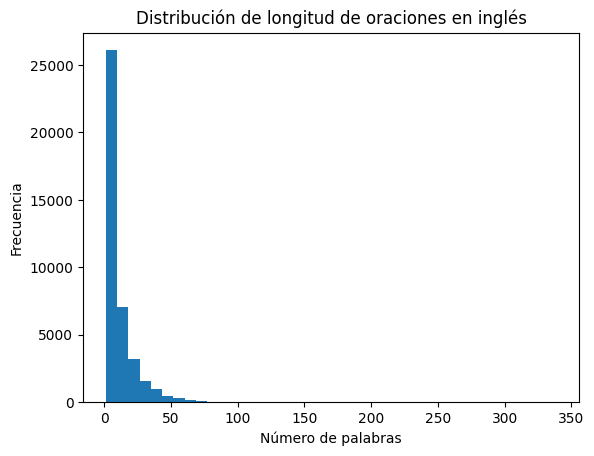

In [17]:
# Etapa 16. Distribución de largo de frases.

import matplotlib.pyplot as plt

longitudes = [len(x.split()) for x in train_ds[src_col]]

plt.hist(longitudes, bins=40)
plt.title("Distribución de longitud de oraciones en inglés")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()


### Etapa 17. Comparación del puntaje SacreBLEU entre EN → ES y ES → EN

En esta etapa se realiza una comparación directa del rendimiento obtenido por los dos modelos de traducción entrenados previamente:

Modelo 1: Inglés → Español (EN → ES)

Modelo 2: Español → Inglés (ES → EN)

Ambos modelos fueron evaluados mediante la métrica SacreBLEU, que mide la similitud entre la traducción generada por el modelo y la referencia humana correspondiente.

El propósito de esta comparación es analizar si existe asimetría en la calidad de traducción entre las dos direcciones del par lingüístico, lo cual es un fenómeno común en sistemas de traducción automática neuronal.

1. Obtención de los puntajes SacreBLEU

Los puntajes obtenidos previamente durante la evaluación manual de los modelos son almacenados en:

result_valid_en_es["score"]

result_valid_es_en["score"]

Cada valor representa la calidad de la traducción en su respectiva dirección.

2. Visualización comparativa

Se construye una gráfica de barras sencilla utilizando matplotlib:

El eje X muestra las dos direcciones del modelo: EN → ES y ES → EN.

El eje Y muestra el valor del puntaje SacreBLEU.

Cada barra permite una comparación visual directa del rendimiento en ambas tareas.

Este enfoque facilita identificar:

si el modelo traduce mejor hacia un idioma que hacia el otro,

si el desempeño es equilibrado entre las direcciones,

o si una de las traducciones presenta mayores dificultades estructurales.

3. Interpretación del resultado

Es común observar diferencias entre la calidad de las traducciones en cada dirección debido a:

variaciones en la complejidad gramatical entre los idiomas,

diferencias en el volumen o calidad de datos del corpus preentrenado,

sesgos del modelo hacia su idioma de entrenamiento predominante,

variaciones en la longitud natural de las oraciones según la lengua.

Independientemente del resultado exacto, esta comparación aporta una visión más completa del comportamiento del sistema de traducción y permite evaluar su desempeño de manera balanceada.

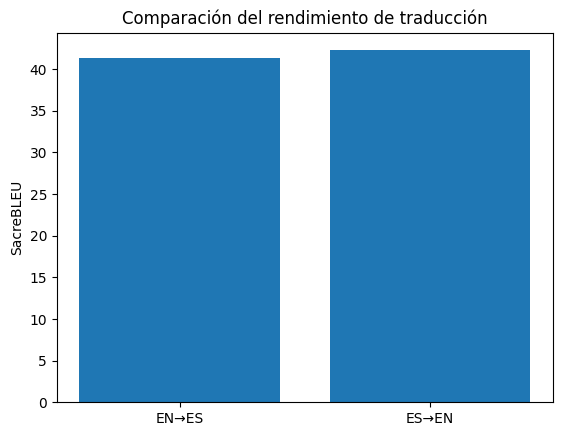

In [18]:
# Etapa 17. Comparación de Bleu entre EN->ES y ES->EN

import matplotlib.pyplot as plt

bleu_scores = [result_valid_en_es["score"], result_valid_es_en["score"]]
labels = ["EN→ES", "ES→EN"]

plt.bar(labels, bleu_scores)
plt.ylabel("SacreBLEU")
plt.title("Comparación del rendimiento de traducción")
plt.show()


### Etapa 18. Demo de despliegue con Gradio

En esta etapa se construye un prototipo de aplicación web para demostrar de forma interactiva el funcionamiento del sistema de traducción automática desarrollado en el proyecto. Para ello se utiliza Gradio, una librería que permite crear interfaces gráficas sencillas directamente desde Python, sin necesidad de implementar un backend o una página web completa.

1. Función de traducción interactiva

Se define una función translate(text, direction) que:

Recibe como entrada:

un texto en inglés o en español,

la dirección de traducción seleccionada por el usuario:

"EN → ES" (inglés a español),

"ES → EN" (español a inglés).

Según la dirección elegida:

añade el prefijo adecuado ("translate English to Spanish: " o "translate Spanish to English: "),

tokeniza el texto con el tokenizador correspondiente,

ejecuta el modelo entrenado (model_en_es o model_es_en) en modo inferencia con generate,

decodifica la secuencia generada para obtener la traducción final en texto.

Esta función encapsula la lógica de inferencia de los dos modelos MarianMT y constituye el núcleo del servicio de traducción.

2. Construcción de la interfaz con Gradio

Se crea una interfaz gr.Interface que incluye:

Entrada de texto (Textbox):
donde el usuario escribe la oración a traducir.

Selector de dirección (Radio):
que permite escoger si la traducción será EN → ES o ES → EN.

Salida de texto (Textbox):
donde se muestra la traducción generada por el modelo.

Además, se añaden:

un título descriptivo para la aplicación,

una descripción breve que explica que se trata de un prototipo basado en la arquitectura Transformer (MarianMT) y en el corpus OPUS-100.

3. Ejecución de la demo

Finalmente, se invoca:

demo.launch()


Lo cual levanta la interfaz gráfica en el entorno de ejecución (Colab), permitiendo que el usuario:

escriba oraciones en inglés o español,

seleccione la dirección de traducción,

y reciba la respuesta generada por el modelo en tiempo casi real.

4. Importancia del despliegue

Esta demo cumple el objetivo de:

mostrar cómo un modelo de PLN puede integrarse en una aplicación práctica,

facilitar la validación cualitativa de las traducciones por parte del usuario,

ilustrar un flujo completo: entrenamiento → evaluación → despliegue interactivo,

y aportar un elemento de prototipo funcional al proyecto, alineado con los requisitos del curso.

In [19]:
# Etapa 18. Demo de despliegue con Gradio

import gradio as gr

model_en_es.eval()
model_es_en.eval()

def translate(text, direction):
    if direction == "EN → ES":
        prefix = "translate English to Spanish: "
        inputs = tokenizer_en_es(prefix + text, return_tensors="pt", truncation=True).to(device)
        with torch.no_grad():
            generated_tokens = model_en_es.generate(**inputs, max_length=80)
        translation = tokenizer_en_es.batch_decode(generated_tokens, skip_special_tokens=True)[0]
    else:
        prefix = "translate Spanish to English: "
        inputs = tokenizer_es_en(prefix + text, return_tensors="pt", truncation=True).to(device)
        with torch.no_grad():
            generated_tokens = model_es_en.generate(**inputs, max_length=80)
        translation = tokenizer_es_en.batch_decode(generated_tokens, skip_special_tokens=True)[0]

    return translation

demo = gr.Interface(
    fn=translate,
    inputs=[
        gr.Textbox(lines=3, label="Texto de entrada"),
        gr.Radio(choices=["EN → ES", "ES → EN"], value="EN → ES", label="Dirección de traducción")
    ],
    outputs=gr.Textbox(lines=3, label="Traducción"),
    title="Demo de Traducción EN ↔ ES con Transformers (OPUS-100)",
    description="Prototipo de aplicación de PLN basado en la arquitectura Transformer (MarianMT)."
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1ed667b9dd668b32b8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## PUNTO 2. Análisis de Sentimientos con Modelos de Lenguaje Preentrenados

En este segundo apartado se desarrolla un sistema de análisis de sentimientos y emociones aplicando modelos preentrenados de Hugging Face, siguiendo un enfoque práctico y comparativo. El objetivo es construir un prototipo funcional capaz de clasificar textos en inglés tanto por emociones como por sentimiento polarizado (negativo, neutro y positivo).

Para ello se seleccionan dos modelos de lenguaje complementarios, cada uno especializado en una tarea diferente del análisis afectivo:

🔹 1. Modelo 1: Clasificador de Emociones

bhadresh-savani/distilbert-base-uncased-emotion

Este modelo está entrenado específicamente para identificar emociones básicas en texto, tales como:

Joy

Sadness

Anger

Fear

Love

Surprise

Su enfoque permite detectar matices emocionales más complejos que un simple análisis de polaridad. Está basado en la arquitectura DistilBERT, lo que lo hace liviano, rápido y adecuado para inferencias en tiempo real.

🔹 2. Modelo 2: Clasificación de Sentimiento (Polaridad)

cardiffnlp/twitter-roberta-base-sentiment-latest

Este modelo RoBERTa ha sido entrenado con datos de Twitter y clasifica el texto en tres categorías principales:

Negative

Neutral

Positive

Su entrenamiento especializado en lenguaje informal y comentarios sociales lo convierte en una herramienta ideal para evaluar textos cortos como tweets, reseñas o comentarios.

En este punto se construye una aplicación de PLN para análisis de sentimientos
usando dos modelos de lenguaje preentrenados de Hugging Face:
1. LukeGPT88/feelings-text-classifier-eng-dataset (clasificación de emociones).
2. cardiffnlp/twitter-roberta-base-sentiment-latest (sentimiento clásico: negativo, neutro, positivo).


### Etapa 1. Importación de Librerías

En esta primera etapa del Punto 2 se realiza la importación de todas las librerías necesarias para implementar el sistema de análisis de sentimientos. Estas herramientas permiten gestionar datasets, ejecutar modelos preentrenados y construir visualizaciones que apoyan el análisis cuantitativo y cualitativo del rendimiento.

Las librerías importadas pueden agruparse en tres categorías principales:

🔹 1. Librerías de Modelado y Procesamiento de Lenguaje Natural

transformers:
Utilizada para cargar modelos de lenguaje preentrenados mediante la interfaz pipeline, simplificando tareas de inferencia en análisis de sentimientos y emociones.

datasets:
Permite cargar corpus especializados, como tweet_eval, utilizado para evaluar el desempeño del modelo RoBERTa en clasificación de sentimiento.

🔹 2. Librerías para Visualización

matplotlib.pyplot y seaborn:
Facilitan la creación de gráficos exploratorios, incluyendo:

histogramas de longitud de texto,

distribución de clases,

matrices de confusión,

gráficos comparativos de frecuencia.

Estas visualizaciones permiten comprender mejor el comportamiento de los modelos y el dataset.

🔹 3. Herramientas para Evaluación Cuantitativa

pandas:
Utilizado para convertir el dataset a un DataFrame y manipular etiquetas desde una estructura tabular.

sklearn.metrics:
Provee métricas fundamentales para evaluar el desempeño del modelo:

Accuracy

F1-score (macro)

Classification report

Confusion matrix

Estas métricas permiten obtener una evaluación objetiva del rendimiento del modelo RoBERTa en el conjunto de prueba.

In [20]:
# Etapa 1. importar librerias

from transformers import pipeline
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


### Etapa 2. Carga del Dataset

En esta etapa se realiza la carga del conjunto de datos que servirá como base para evaluar el rendimiento de los modelos de análisis de sentimientos. Para este propósito se utiliza el dataset tweet_eval, una colección ampliamente utilizada en investigación de PLN enfocada en tareas de clasificación de sentimiento y emoción en mensajes cortos publicados en Twitter.

🔹 1. Selección del Subconjunto “sentiment”

El dataset tweet_eval contiene varias categorías (irony, hate, emoji, stance, etc.), pero para esta práctica se selecciona específicamente el subconjunto:

tweet_eval/sentiment

Este subconjunto contiene tweets en inglés etiquetados según su polaridad emocional:

0 → Negative

1 → Neutral

2 → Positive

Estas etiquetas facilitan la evaluación cuantitativa del modelo RoBERTa especializado en sentimiento clásico.

🔹 2. Carga mediante load_dataset

A través de la función load_dataset de Hugging Face Datasets, los datos se descargan y estructuran automáticamente en sus particiones:

train

validation

test

Cada partición incluye miles de ejemplos, permitiendo una evaluación robusta tanto en fase exploratoria como en la validación final.

🔹 3. Objetivo de la Etapa

El propósito de esta etapa es:

Disponer del dataset organizado en sus particiones formales.

Inspeccionar ejemplos reales para comprender el tipo de lenguaje que debe analizar el modelo.

Preparar la base sobre la cual se harán las evaluaciones cuantitativas (RoBERTa) y cualitativas (clasificador de emociones).

Con la carga del dataset completada, el proyecto queda listo para avanzar hacia la Etapa 3, donde se separan las particiones y se inspeccionan etiquetas y ejemplos.

In [21]:
# Etapa 2. Cargar dataset

# Dataset de tweets con etiquetas de sentimiento: negative / neutral / positive
sentiment_ds = load_dataset("tweet_eval", "sentiment")

sentiment_ds


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Etapa 3. Separación de los Conjuntos Train/Valid/Test y Exploración de Etiquetas

Una vez cargado el dataset tweet_eval/sentiment, esta etapa se centra en organizar las particiones disponibles y comprender la estructura de las etiquetas que utilizarán los modelos de análisis de sentimientos. Esta división es fundamental para garantizar evaluaciones adecuadas y reproducibles.

🔹 1. Separación de Particiones

El dataset ya viene estructurado en tres conjuntos:

Train → utilizado para análisis exploratorio y preparación del modelo.

Validation → útil para pruebas intermedias en escenarios de entrenamiento.

Test → reservado para la evaluación final del desempeño del modelo.

Por claridad y buena práctica, cada split se asigna a una variable independiente:

train_tweets = sentiment_ds["train"]
valid_tweets = sentiment_ds["validation"]
test_tweets  = sentiment_ds["test"]


Esta separación permite manipular y analizar cada conjunto de manera ordenada y explícita.

🔹 2. Obtención de los Nombres de las Etiquetas

El dataset maneja las etiquetas en formato numérico (0, 1, 2). Para interpretarlas correctamente, se obtiene el mapa de etiquetas mediante:

label_names = sentiment_ds["train"].features["label"].names


Lo cual retorna típicamente:

0 → negative

1 → neutral

2 → positive

Este paso es esencial, ya que los modelos preentrenados operan sobre etiquetas textuales y la evaluación requiere comparar predicciones con los nombres reales de las clases.

🔹 3. Inspección de un Tweet Ejemplo

Para familiarizarse con el tipo de datos, se imprime un ejemplo del conjunto de entrenamiento. Esto permite observar:

el estilo informal típico de Twitter,

la presencia de abreviaciones, emojis o expresiones coloquiales,

y cómo estos factores pueden influir en la predicción de los modelos.

In [22]:
# Etapa 3. Separar Train/Valid/Test y ver etiquetas

train_tweets = sentiment_ds["train"]
valid_tweets = sentiment_ds["validation"]
test_tweets  = sentiment_ds["test"]

label_names = sentiment_ds["train"].features["label"].names
print("Etiquetas del dataset tweet_eval/sentiment:", label_names)
print("Ejemplo de tweet:", train_tweets[0])


Etiquetas del dataset tweet_eval/sentiment: ['negative', 'neutral', 'positive']
Ejemplo de tweet: {'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'label': 2}


### Etapa 4. Análisis Exploratorio Simple

Antes de aplicar los modelos de análisis de sentimientos, es fundamental realizar un análisis exploratorio de datos (EDA) para comprender mejor la estructura, distribución y características del dataset. Este proceso aporta una visión preliminar que facilita interpretar los resultados posteriores y detectar posibles sesgos o desbalances en las clases.

El análisis exploratorio desarrollado incluye dos componentes principales:

🔹 1. Distribución de Clases en el Conjunto de Entrenamiento

Se construye un DataFrame con el texto de los tweets y sus etiquetas originales. A partir de esto se calcula la frecuencia de cada clase utilizando un gráfico de barras generado con Seaborn.

Este primer análisis permite identificar si el dataset presenta:

desbalance de clases,

predominancia del sentimiento neutral,

menor presencia de sentimientos extremos (positive y negative).

Comprender esta distribución es clave, ya que los modelos de PLN tienden a verse influenciados por el nivel de representación de cada categoría.

🔹 2. Distribución de la Longitud de los Tweets

Se calcula la cantidad de palabras por tweet y se genera un histograma de longitudes. Esto permite analizar:

si los textos suelen ser muy cortos,

si presentan variabilidad significativa,

y si existe algún patrón que pueda impactar el desempeño del modelo.

Dado que los tweets son mensajes breves (generalmente entre 5 y 25 palabras), esta visualización confirma la naturaleza compacta del corpus y ayuda a anticipar el comportamiento de los modelos, especialmente el de emociones.

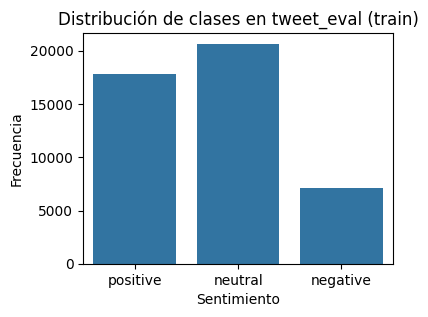

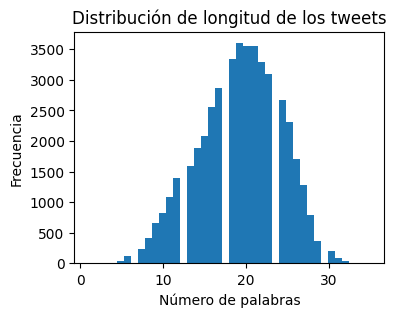

In [23]:
# Etapa 4. Analisis exploratorio simple

# Pasar una muestra a DataFrame
df_train = pd.DataFrame({
    "text": train_tweets["text"],
    "label_id": train_tweets["label"]
})
df_train["label"] = df_train["label_id"].apply(lambda i: label_names[i])

# Conteo de clases
plt.figure(figsize=(4,3))
sns.countplot(data=df_train, x="label")
plt.title("Distribución de clases en tweet_eval (train)")
plt.xlabel("Sentimiento")
plt.ylabel("Frecuencia")
plt.show()

# Longitud de los tweets (en palabras)
df_train["length_words"] = df_train["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(4,3))
plt.hist(df_train["length_words"], bins=40)
plt.title("Distribución de longitud de los tweets")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()


### Etapa 5. Carga de modelos de lenguaje mediante pipelines

En esta etapa se inicializan los modelos de lenguaje preentrenados que serán utilizados para el análisis automático de sentimientos y emociones. Para simplificar el uso de estos modelos, se emplea la abstracción de pipeline proporcionada por la librería Transformers de Hugging Face.

El uso de pipeline permite:

cargar un modelo preentrenado y su tokenizador asociado,

definir la tarea a realizar (en este caso, text-classification),

aplicar el modelo directamente sobre texto en lenguaje natural,

obtener predicciones con sus etiquetas y puntajes de confianza.

🔹 1. Modelo 1 – Clasificador de Emociones (DistilBERT)

Se define el primer pipeline:

feelings_clf = pipeline(
    task="text-classification",
    model="bhadresh-savani/distilbert-base-uncased-emotion"
)


Este modelo está entrenado para realizar clasificación de emociones y produce etiquetas como:

joy

sadness

anger

fear

love

surprise

Su base arquitectónica es DistilBERT, una versión comprimida de BERT que mantiene un alto desempeño con menor cantidad de parámetros, lo que lo hace eficiente para inferencia en entornos de recursos limitados.

🔹 2. Modelo 2 – Clasificador de Sentimiento (RoBERTa)

El segundo pipeline se define como:

roberta_clf = pipeline(
    task="text-classification",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest"
)


Este modelo RoBERTa está especializado en análisis de sentimiento clásico sobre tweets, asignando una de las siguientes categorías:

negative

neutral

positive

Su entrenamiento específico sobre datos de Twitter lo hace especialmente adecuado para el dataset tweet_eval/sentiment, permitiendo una evaluación coherente y realista.

🔹 3. Inspección de etiquetas de cada modelo

Tras crear los pipelines, se imprime la configuración de etiquetas (id2label) de ambos modelos. Esto permite:

confirmar las clases que cada modelo es capaz de predecir,

entender las salidas que se visualizarán en etapas posteriores,

y garantizar que la interpretación de resultados sea correcta.

In [ ]:
# Etapa 5. Cargar modelos de lenguaje (pipeLines)

# Modelo 1: emociones (joy, sadness, anger, fear, love, surprise)
feelings_clf = pipeline(
    task="text-classification",
    model="bhadresh-savani/distilbert-base-uncased-emotion"
)

# Modelo 2: RoBERTa para sentimiento clásico (negativo / neutro / positivo)
roberta_clf = pipeline(
    task="text-classification",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

print("Labels feelings_clf:", feelings_clf.model.config.id2label)
print("Labels roberta_clf:", roberta_clf.model.config.id2label)


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

### Etapa 6. Evaluación cuantitativa del modelo RoBERTa en test

En esta etapa se realiza la evaluación cuantitativa formal del modelo de sentimiento cardiffnlp/twitter-roberta-base-sentiment-latest utilizando el conjunto de prueba (test) del dataset tweet_eval/sentiment. El propósito es medir de forma objetiva el desempeño del modelo frente a datos reales, no vistos durante el entrenamiento original.

🔹 1. Selección del subconjunto de evaluación

Por eficiencia de cómputo, se seleccionan hasta 1000 ejemplos del conjunto de prueba:

Esto permite obtener estadísticas representativas sin extender demasiado los tiempos de ejecución.

Los ejemplos seleccionados se procesan uno por uno mediante el pipeline de RoBERTa.

🔹 2. Proceso de evaluación

La función evaluate_roberta_on_tweets realiza:

a) Obtención de etiquetas reales (ground truth)

Convierte los IDs numéricos del dataset (0, 1, 2) a sus etiquetas textuales correspondientes:

negative

neutral

positive

b) Generación de predicciones

Para cada tweet:

out = clf(t)[0]
pred_labels.append(out["label"].lower())


Se registra tanto la etiqueta predicha como su puntaje de confianza.

c) Cálculo de métricas estándar

Se utilizan métricas clásicas de clasificación:

Accuracy → proporción de predicciones correctas.

F1-score macro → media del F1 por clase, útil cuando hay desbalance de etiquetas.

Classification Report → incluye precision, recall y F1 por clase.

Estas métricas permiten evaluar de forma precisa qué tan bien RoBERTa identifica cada tipo de sentimiento.

🔹 3. Resultados esperados

Debido a que el modelo fue entrenado sobre tweets, se espera un desempeño sólido, especialmente en:

clases mayoritarias (neutral),

mensajes directos o explícitos,

texto con carga emocional clara.

Los desafíos típicos incluyen:

ironía,

sarcasmo,

tweets ambiguos,

expresiones coloquiales o abreviadas.

In [ ]:
# Etapa 6. Evaluación cuantitativa del modelo RoBERTa en test

def evaluate_roberta_on_tweets(clf, dataset, label_names, num_samples=1000):
    subset = dataset.select(range(min(num_samples, len(dataset))))
    texts = subset["text"]
    true_ids = subset["label"]
    true_labels = [label_names[i] for i in true_ids]

    pred_labels = []
    for t in texts:
        out = clf(t)[0]   # {'label': 'positive', 'score': ...}
        # Normalizamos a minúsculas por si acaso
        pred_labels.append(out["label"].lower())

    acc = accuracy_score(true_labels, pred_labels)
    f1  = f1_score(true_labels, pred_labels, average="macro")

    print(f"Accuracy RoBERTa (test, {len(true_labels)} muestras): {acc:.4f}")
    print(f"F1 macro RoBERTa: {f1:.4f}")
    print("\nClassification report RoBERTa:\n")
    print(classification_report(true_labels, pred_labels))

    return true_labels, pred_labels

true_labels_rb, pred_labels_rb = evaluate_roberta_on_tweets(
    roberta_clf, test_tweets, label_names, num_samples=1000
)


### Etapa 7. Matriz de Confusión para el Modelo RoBERTa

Tras realizar la evaluación cuantitativa del modelo RoBERTa en la etapa anterior, es necesario complementar el análisis mediante la matriz de confusión, una herramienta fundamental en tareas de clasificación. Esta visualización permite identificar de forma clara cómo se comporta el modelo respecto a cada una de las clases del dataset.

🔹 1. ¿Qué es una matriz de confusión?

La matriz de confusión es una tabla que compara:

las etiquetas reales del dataset,

contra las predicciones generadas por el modelo.

Cada celda representa el número de ejemplos clasificados como una combinación de:

Etiqueta real → Fila

Predicción del modelo → Columna

Esto permite detectar patrones como:

clases que son fáciles de predecir,

clases donde el modelo falla con frecuencia,

confusiones recurrentes entre etiquetas específicas.

🔹 2. Aplicación al modelo RoBERTa

Usando la función:

cm = confusion_matrix(true_labels_rb, pred_labels_rb, labels=label_names)


se genera la matriz considerando las tres clases del problema:

negative

neutral

positive

Posteriormente, con Seaborn se crea un mapa de calor (heatmap) para una visualización más intuitiva:

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=label_names, yticklabels=label_names)

🔹 3. Interpretación de la matriz de confusión

Este gráfico permite observar:

Cuántos ejemplos de cada clase fueron correctamente identificados (diagonal principal).

En qué casos el modelo confunde una clase con otra, por ejemplo:

mensajes neutrales clasificados como positivos,

sentimientos negativos que se interpretan como neutrales.

Este tipo de confusiones es especialmente común en textos breves como tweets.

In [ ]:
# Etapa 7. Matriz de confusión para modelo RoBERTa

cm = confusion_matrix(true_labels_rb, pred_labels_rb, labels=label_names)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión – RoBERTa en tweet_eval (test)")
plt.tight_layout()
plt.show()


### Etapa 8. Validación Cualitativa del Feeling Classifier

Después de evaluar cuantitativamente al modelo RoBERTa, en esta etapa se realiza una validación cualitativa del modelo encargado de identificar emociones:
bhadresh-savani/distilbert-base-uncased-emotion.

A diferencia del análisis de sentimiento polarizado, este modelo predice emociones humanas específicas, permitiendo capturar matices afectivos que van más allá de la simple clasificación negativo–neutral–positivo. Por ello, su evaluación se realiza desde una perspectiva descriptiva y exploratoria.

🔹 1. Selección de una muestra representativa

Para este análisis se utiliza un subconjunto de hasta 500 ejemplos del conjunto de prueba (test) del dataset tweet_eval. Aunque este dataset está enfocado en polaridad, su variedad de contenido permite inspeccionar cómo el modelo emocional responde ante textos reales.

Los ejemplos se procesan uno a uno con el pipeline:

clf(text)[0]["label"]


Registrando únicamente la emoción predicha.

🔹 2. Conteo y análisis de frecuencias

A partir de las predicciones, se construye un conteo de frecuencia utilizando collections.Counter, el cual refleja:

qué emociones son detectadas con mayor frecuencia,

posibles sesgos inherentes al modelo,

tendencias respecto al lenguaje emocional presente en los tweets.

El resultado se transforma en un DataFrame y se visualiza mediante un gráfico de barras, lo que permite observar de manera inmediata la distribución general de las emociones predichas.

🔹 3. Interpretación de la distribución emocional

El gráfico resultante proporciona información clave:

Si predomina la emoción joy, es posible que el modelo tienda a sobreinterpretar expresiones positivas.

Si sadness o anger aparecen con alta frecuencia, podría indicar sensibilidad a lenguaje emocional negativo.

Una aparición moderada de fear, love o surprise revela la capacidad del modelo para identificar estados afectivos menos frecuentes.

Dado que el dataset no está etiquetado por emociones, esta evaluación no busca exactitud, sino observar el comportamiento emergente del modelo.

In [ ]:
# Etapa 8. Validación cualitativa de feeling classifier

import collections

def feelings_distribution(clf, dataset, num_samples=500):
    subset = dataset.select(range(min(num_samples, len(dataset))))
    texts = subset["text"]

    preds = [clf(t)[0]["label"] for t in texts]
    counts = collections.Counter(preds)

    df = pd.DataFrame({
        "feeling": list(counts.keys()),
        "count": list(counts.values())
    }).sort_values("count", ascending=False)

    plt.figure(figsize=(5,3))
    sns.barplot(data=df, x="feeling", y="count")
    plt.xticks(rotation=45)
    plt.title("Distribución de emociones predichas por feelings_clf")
    plt.xlabel("Emoción predicha")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    return df

feelings_df = feelings_distribution(feelings_clf, test_tweets, num_samples=500)
feelings_df


### Etapa 9. Comparativa de modelos

En esta etapa se realiza una comparación directa entre los dos modelos empleados en el Punto 2:

Clasificador de emociones
bhadresh-savani/distilbert-base-uncased-emotion

Clasificador de sentimiento polarizado
cardiffnlp/twitter-roberta-base-sentiment-latest

El propósito es contrastar cómo cada modelo interpreta un mismo conjunto de textos, resaltando diferencias en:

el enfoque del modelo,

la naturaleza de sus predicciones,

su capacidad para capturar matices afectivos,

y el tipo de información que aportan para el análisis de sentimiento.

🔹 1. Selección de ejemplos aleatorios para comparación

Para esta evaluación cualitativa, se seleccionan 5 tweets aleatorios del conjunto de prueba (test_tweets). Cada uno es analizado por:

el modelo de emociones (que produce etiquetas como joy, sadness, etc.),

y el modelo RoBERTa (que produce etiquetas negative, neutral o positive).

Esta doble predicción permite observar cómo un mismo texto puede ser interpretado de manera distinta según la arquitectura o el tipo de entrenamiento del modelo.

🔹 2. Presentación de resultados

Para cada tweet seleccionado, se muestran:

Texto original

Etiqueta real del dataset (negative, neutral, positive)

Predicción del modelo emocional, acompañada de su score

Predicción del modelo RoBERTa, con su score

De esta forma se pueden analizar situaciones como:

Tweets clasificados como neutral por RoBERTa, pero que contienen señales emocionales detectadas por DistilBERT.

Casos en que ambos modelos concuerdan: por ejemplo, positive ↔ joy.

Situaciones ambiguas donde los modelos difieren en su interpretación.

🔹 3. Valor analítico de la comparación

Esta comparación es especialmente útil para:

Identificar la complementariedad entre ambos enfoques:

el modelo de emociones aporta riqueza semántica,

mientras que RoBERTa aporta robustez en clasificación polarizada.

Visualizar cómo se comportan los modelos ante lenguaje informal, propio de Twitter.

Mostrar que un modelo no sustituye al otro, sino que ambos pueden integrarse para análisis más profundos.

In [ ]:
# Etapa 9. Comparativa de modelos

def mostrar_ejemplos_ambos_modelos(dataset, n=5):
    subset = dataset.shuffle(seed=42).select(range(n))
    for i, row in enumerate(subset):
        text = row["text"]
        true_label = label_names[row["label"]]

        f_out = feelings_clf(text)[0]
        r_out = roberta_clf(text)[0]

        print("="*80)
        print(f"Ejemplo {i+1}")
        print("Texto:", text)
        print("Sentimiento real (tweet_eval):", true_label)
        print(f"Feelings classifier → {f_out['label']} (score={f_out['score']:.2f})")
        print(f"RoBERTa classifier → {r_out['label']} (score={r_out['score']:.2f})")

mostrar_ejemplos_ambos_modelos(test_tweets, n=5)


### Etapa 10. Prototipo de Despliegue con Gradio

En esta etapa se construye un prototipo interactivo que integra los dos modelos de análisis afectivo desarrollados previamente. El objetivo es proporcionar una herramienta accesible que permita evaluar textos en tiempo real y observar simultáneamente:

la emoción predominante detectada por el modelo emocional (DistilBERT),

y la polaridad del sentimiento identificada por el modelo RoBERTa (twitter-roberta-base-sentiment-latest).

Gradio permite encapsular ambos modelos dentro de una interfaz sencilla, ejecutable directamente desde el notebook, sin necesidad de implementar un servidor web complejo.

🔹 1. Función principal del prototipo

Se define la función analizar_texto_sentimientos(text), la cual:

Recibe un texto en inglés ingresado por el usuario.

Obtiene la emoción más probable mediante el pipeline de DistilBERT.

Obtiene el sentimiento polarizado mediante el pipeline RoBERTa.

Retorna una estructura JSON con ambas predicciones y sus respectivos puntajes.

La salida combinada permite analizar tanto el tono general del mensaje como la emoción específica que lo caracteriza.

🔹 2. Construcción de la interfaz con Gradio

La interfaz se crea mediante:

demo_sentimientos = gr.Interface(
    fn=analizar_texto_sentimientos,
    inputs=gr.Textbox(lines=3, label="Texto en inglés"),
    outputs="json",
    ...
)


Elementos clave:

Entrada: un Textbox donde el usuario escribe un texto libre.

Salida: un objeto JSON que muestra las predicciones de ambos modelos.

Título y descripción: proporcionan contexto sobre los modelos utilizados.

Esta configuración hace que la herramienta sea intuitiva, clara y práctica para cualquier usuario.

🔹 3. Ejecución del prototipo

Finalmente, se activa la interfaz llamando:

demo_sentimientos.launch()


Lo que despliega una ventana interactiva dentro del notebook donde el usuario puede ingresar textos y observar los resultados de forma inmediata.

In [ ]:
# Etapa 10. Prototipo de despliegue con Gradio

import gradio as gr

def analizar_texto_sentimientos(text):
    # Modelo 1: emociones
    f_res = feelings_clf(text)[0]
    # Modelo 2: sentimiento polaridad
    r_res = roberta_clf(text)[0]

    return {
        "Feelings classifier (emociones)": {
            "label": f_res["label"],
            "score": float(f_res["score"])
        },
        "RoBERTa sentiment (polaridad)": {
            "label": r_res["label"],
            "score": float(r_res["score"])
        }
    }

demo_sentimientos = gr.Interface(
    fn=analizar_texto_sentimientos,
    inputs=gr.Textbox(lines=3, label="Texto en inglés"),
    outputs="json",
    title="Punto 2 – Análisis de sentimientos con dos modelos de lenguaje",
    description=(
        "Modelo 1: LukeGPT88/feelings-text-classifier-eng-dataset (emociones). \n"
        "Modelo 2: cardiffnlp/twitter-roberta-base-sentiment-latest (sentimiento clásico)."
    )
)

demo_sentimientos.launch()
